# Introduction

In this work, I decided to write my own implementation of the k-means algorithm and compare its performance with the algorithm implemented in the Scikit-learn library.

In [1]:
import pandas as pd
import random
import seaborn as sns
import matplotlib.ticker
from matplotlib import pyplot as plt
from typing import List

## Data loading and normalization

In [2]:
df = pd.read_csv('/kaggle/input/wine-dataset-for-clustering/wine-clustering.csv')
df1 = df.copy()
df1 = (df1 - df1.min()) / (df1.max() - df1.min())
df1.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.573840,0.283019,0.593060,0.372014,0.455285,0.970696,0.561341
1,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642
2,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933
3,0.878947,0.239130,0.609626,0.319588,0.467391,0.989655,0.664557,0.207547,0.558360,0.556314,0.308943,0.798535,0.857347
4,0.581579,0.365613,0.807487,0.536082,0.521739,0.627586,0.495781,0.490566,0.444795,0.259386,0.455285,0.608059,0.325963


# Algorithm implementation

In [3]:
#A function that calculates the distance from a point to the mean
def distance(l1: List[float], l2: List[float]) -> float:
    assert len(l1) == len(l2)
    return sum([(a1 - a2)**2 for a1, a2 in zip(l1, l2)])

#A function that receives a data frame and the number of clusters as input
def clustering(df: pd.DataFrame, n_clusters: int) -> List[int]:
    columns = df.columns
    
    #Assignment of random coordinates to cluster centers
    coord_means = [[random.random() for _ in range(len(columns))] for _ in range(n_clusters)]
    close_mean1 = pd.Series([-1 for _ in range(df.shape[0])])
    close_mean2 = pd.Series([-2 for _ in range(df.shape[0])])
    
    #The learning process stops when not a single point has changed its cluster during the iteration
    while list(close_mean1) != list(close_mean2):
        close_mean1 = close_mean2
        close_mean2 = pd.Series([-1 for _ in range(df.shape[0])])
        
        #Finding the nearest cluster center for each point
        for i in range(df.shape[0]):
            dist = []
            for coord_mean in coord_means:
                dist.append(distance(list(df.iloc[i,]), coord_mean))
            close_mean2[i] = dist.index(min(dist))
        
        #Calculation of new coordinates for cluster centers
        for j, coord_mean in enumerate(coord_means):
            if len(df[close_mean2 == j]) != 0:
                for k, column in enumerate(columns):
                    coord_mean[k] = df.loc[close_mean2 == j, column].mean()
            else:
                for k, column in enumerate(columns):
                    coord_mean[k] = random.random()
    
    return close_mean2

## Algorithm analysis
First we need to figure out how the number of given clusters compares to the number of received ones.

In [4]:
random.seed(1)

for i in range(1, 11):
    df1[i] = clustering(df1, i)

df1.iloc[:, 13:].nunique()

1     1
2     2
3     3
4     4
5     4
6     4
7     5
8     3
9     3
10    4
dtype: int64

Apparently, the number of clusters produced by the algorithm depends on the data. The same result was given by the KMeans algorithm of the Scikit-learn library with a maximum number of clusters of about 5 - 7.
### Calculation of the sum of distances
The sum of distances allows us to determine the optimal number of clusters.

In [5]:
n_clusters = []
sum_dist = []

for i in range(1, 11):
    clusters = sorted(df1[i].unique())
    s = 0
    
    for cluster in clusters:
        coord = list(df1.loc[df1[i] == cluster, :'Proline'].mean())
        
        for ind in df1.loc[df1[i] == cluster,].index:
            s += distance(list(df1.iloc[ind, :13]), coord)
            
    n_clusters.append(len(clusters))
    sum_dist.append(s)

### Visualization of the received data

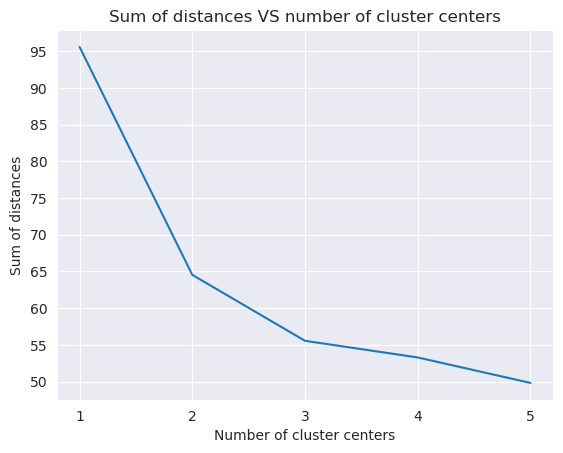

In [6]:
sns.set_style('darkgrid')
plot = sns.lineplot(x = n_clusters, y = sum_dist, errorbar = None)
plot.set(title = 'Sum of distances VS number of cluster centers', xlabel = 'Number of cluster centers', ylabel = 'Sum of distances')
plot.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
plot.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))
plt.show()

The graph says that the optimal number of clusters is 3.
# Performance comparison

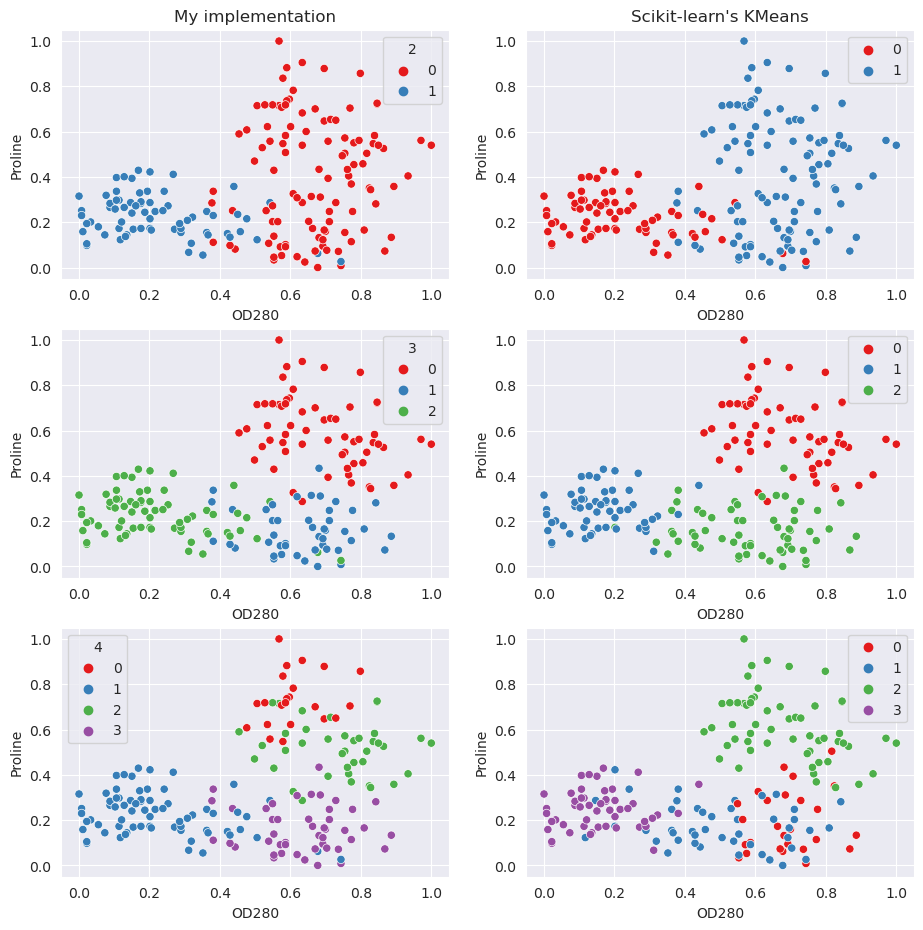

In [7]:
from sklearn.cluster import KMeans

df2 = df.copy()
df2 = (df2 - df2.min()) / (df2.max() - df2.min())

fig, ax = plt.subplots(3, 2, figsize = (11, 11))
ax[0, 0].set(title = 'My implementation')
ax[0, 1].set(title = 'Scikit-learn\'s KMeans')

for i in range(3):
    kmeans = KMeans(n_clusters = i + 2, random_state = 0).fit(df2)
    pred = kmeans.predict(df2)
    sns.scatterplot(x = df1.iloc[:, 11], y = df1.iloc[:, 12], ax = ax[i, 0], hue = df1[i + 2], palette = 'Set1')
    sns.scatterplot(x = df2.iloc[:, 11], y = df2.iloc[:, 12], ax = ax[i, 1], hue = pred, palette = 'Set1')

Only when dividing the data into 4 clusters are there noticeable performance differences between my implementation of the algorithm and the implementation of the Scikit-learn library. And we still don't know who is right ;)